# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 36 kB/s 


In [3]:
!pip install radiant_mlhub

     |████████████████████████████████| 62 kB 576 kB/s 
     |████████████████████████████████| 201 kB 70.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 168 kB/s 


In [5]:

# Required libraries
import os
import tarfile
import json
import pandas as pd
from pathlib import Path
from radiant_mlhub.client import _download as download_file

import datetime
import rasterio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import ndimage 
import numpy.ma as ma

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit

# loading data

In [11]:
DOWNLOAD_S1 = True # If you set this to true then the Sentinel-1 data will be downloaded

# Select which imagery bands you'd like to download here
DOWNLOAD_BANDS = {
    'B01': True,
    'B02': True,
    'B03': True,
    'B04': True,
    'B05': True,
    'B06': True,
    'B07': True,
    'B08': True,
    'B8A': True,
    'B09': True,
    
    'B11': True,
    'B12': True,
    'CLM': True
}

In [12]:
os.environ['MLHUB_API_KEY'] = 'a6bb13078fcfa091ebd00341a91752e560a434b58cab5daf5ac1ccdacc836dac'
FOLDER_BASE = 'ref_south_africa_crops_competition_v1'

def download_archive(archive_name):
    if os.path.exists(archive_name.replace('.tar.gz', '')):
        return
    
    print(f'Downloading {archive_name} ...')
    download_url = f'https://radiant-mlhub.s3.us-west-2.amazonaws.com/archives/{archive_name}'
    download_file(download_url, '.')
    print(f'Extracting {archive_name} ...')
    with tarfile.open(archive_name) as tfile:
        tfile.extractall()
    os.remove(archive_name)

for split in ['test']:
    # Download the labels
    labels_archive = f'{FOLDER_BASE}_{split}_labels.tar.gz'
    download_archive(labels_archive)
    
    # Download Sentinel-1 data
    if DOWNLOAD_S1:
        s1_archive = f'{FOLDER_BASE}_{split}_source_s1.tar.gz'
        download_archive(s1_archive)
        

    for band, download in DOWNLOAD_BANDS.items():
        if not download:
            continue
        s2_archive = f'{FOLDER_BASE}_{split}_source_s2_{band}.tar.gz'
        download_archive(s2_archive)
        
def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()
        
def load_df(collection_id):
    split = collection_id.split('_')[-2]
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
        
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])
            
        for link in item['links']:
            if link['rel'] != 'source':
                continue
            source_item_id = link['href'].split('/')[-2]
            
            if source_item_id.find('_s1_') > 0 and not DOWNLOAD_S1:
                continue
            elif source_item_id.find('_s1_') > 0:
                for band in ['VV', 'VH']:
                    asset_path = Path(f'{FOLDER_BASE}_{split}_source_s1/{source_item_id}/{band}.tif').resolve()
                    date = '-'.join(source_item_id.split('_')[10:13])
                    
                    rows.append([
                        tile_id,
                        f'{date}T00:00:00Z',
                        's1',
                        band,
                        asset_path
                    ])
                
            if source_item_id.find('_s2_') > 0:
                for band, download in DOWNLOAD_BANDS.items():
                    if not download:
                        continue
                    
                    asset_path = Path(f'{FOLDER_BASE}_{split}_source_s2_{band}/{source_item_id}_{band}.tif').resolve()
                    date = '-'.join(source_item_id.split('_')[10:13])
                    rows.append([
                        tile_id,
                        f'{date}T00:00:00Z',
                        's2',
                        band,
                        asset_path
                    ])
            
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

#train_df = load_df(f'{FOLDER_BASE}_train_labels')
test_df = load_df(f'{FOLDER_BASE}_test_labels')

  0%|          | 0/10.9 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_labels.tar.gz ...


  0%|          | 0/713.1 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B01.tar.gz ...


  0%|          | 0/2226.4 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B02.tar.gz ...


  0%|          | 0/2454.4 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B03.tar.gz ...


  0%|          | 0/2706.0 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B04.tar.gz ...


  0%|          | 0/1930.4 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B05.tar.gz ...


  0%|          | 0/1980.9 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B06.tar.gz ...


  0%|          | 0/2002.0 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B07.tar.gz ...


  0%|          | 0/2877.3 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B08.tar.gz ...


  0%|          | 0/2003.0 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B8A.tar.gz ...


  0%|          | 0/910.7 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B09.tar.gz ...


  0%|          | 0/1950.2 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B11.tar.gz ...


  0%|          | 0/1922.3 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_B12.tar.gz ...


  0%|          | 0/10.4 [00:00<?, ?M/s]

Extracting ref_south_africa_crops_competition_v1_test_source_s2_CLM.tar.gz ...


In [13]:
test_df['datetime']=pd.to_datetime(test_df['datetime'])


In [14]:
test_df['month']=test_df['datetime'].dt.month
test_df['week']=test_df['datetime'].dt.isocalendar().week

In [15]:
test_df['day']=test_df['datetime'].dt.day
test_df['fortnight']=np.where(test_df.day<15,1,2)

In [16]:
test_df.shape

(808110, 9)

# sentinel1

In [12]:
sentinel1_test=test_df[test_df.satellite_platform=='s1']
sentinel1_fortnight=sentinel1_test.groupby(['tile_id','month','fortnight','asset']).first().reset_index()
info=test_df[(test_df.asset=='field_ids')|(test_df.asset=='labels')]

In [ ]:
def sentinel1(data,month0=4):
  field_ndvi=[]
  for date in data.month.unique():
    month_i=[]
    for tile in data.tile_id.unique():
     
      tile_df=data[(data.tile_id==tile) & (data.month==date)]
      
      VV1=rasterio.open(tile_df[(tile_df['asset']=='VV')&(tile_df['fortnight']==1)]['file_path'].values[0]).read(1)
      VH1=rasterio.open(tile_df[(tile_df['asset']=='VH')&(tile_df['fortnight']==1)]['file_path'].values[0]).read(1)

      VV2=rasterio.open(tile_df[(tile_df['asset']=='VV')&(tile_df['fortnight']==2)]['file_path'].values[0]).read(1)
      VH2=rasterio.open(tile_df[(tile_df['asset']=='VH')&(tile_df['fortnight']==2)]['file_path'].values[0]).read(1)
    
      tile_fields=rasterio.open(info[(info.tile_id==tile)&(info.asset=='field_ids')]['file_path'].values[0]).read(1)
      ids=np.unique(tile_fields.flatten())

      for field in ids:
        if (field==0):
          continue
       
        mask_VV1=ma.masked_array(VV1, np.where(tile_fields==field,0,1).astype(int))
        mask_VH1=ma.masked_array(VH1, np.where(tile_fields==field,0,1).astype(int))
        
        mask_VV2=ma.masked_array(VV2, np.where(tile_fields==field,0,1).astype(int))
        mask_VH2=ma.masked_array(VH2, np.where(tile_fields==field,0,1).astype(int))
        
        if (date==month0):
          
          field_ndvi.append((tile,field,np.mean(mask_VV1),np.mean(mask_VH1),np.mean(mask_VV2),np.mean(mask_VH2)))

        else:
          month_i.append([np.mean(mask_VV1),np.mean(mask_VH1),np.mean(mask_VV2),np.mean(mask_VH2)])



    if (date==month0):
      train=pd.DataFrame(field_ndvi,columns=['tile_id','field_id',f'VV1_median_{int(date)}',f'VH1_median_{int(date)}',f'VV2_median_{int(date)}',f'VH2_median_{int(date)}'])
    else: 
      train[[f'VV1_median_{int(date)}',f'VH1_median_{int(date)}',f'VV2_median_{int(date)}',f'VH2_median_{int(date)}']]=month_i

  

  return train

In [ ]:
#executing this cell will take time, the output of this cell is cloudy(dataframe) which can be directly obtained
#by executing the next cell
sentinel1_ft=sentinel1(sentinel1_test)

In [6]:
sentinel1_ft=pd.read_parquet('/content/drive/MyDrive/spot_the_crop/sentinel1_ft_test.parquet')

In [8]:
sentinel1_ft.drop('tile_id',axis=1,inplace=True)

# cloudless image selection 


In [9]:
#in each month look for the date in which CLM is all 0s


def cloudless(data):
  for tile in data.tile_id.unique():
    tile_df=data[(data.tile_id==tile)&(data.satellite_platform=='s2')]
    for date in tile_df.datetime.unique():
      src_mask=rasterio.open(tile_df[(tile_df.datetime==date)&(tile_df['asset']=='CLM')]['file_path'].values[0])
      if (np.max(src_mask.read(1))==0):
        data.loc[(data.tile_id==tile) & (data.datetime==date),'cloudless']=0
      if (np.max(src_mask.read(1))==255):
        data.loc[(data.tile_id==tile) & (data.datetime==date),'cloudless']=np.sum(src_mask.read(1))/255

      if (np.max(src_mask.read(1))==1):
        data.loc[(data.tile_id==tile) & (data.datetime==date),'cloudless']=np.sum(src_mask.read(1))+0.02
 

In [18]:
#lasts 53 minutes
test_cloudless=test_df.copy()
cloudless(test_cloudless)

**cloudless fortnight**

In [19]:
test_cloudless.set_index(['tile_id','month','fortnight'],inplace=True)
test_cloudless['best']=test_cloudless.groupby(['tile_id','month','fortnight']).cloudless.min()
test_cloudless.reset_index(inplace=True)

In [20]:
cloud_free_test=test_cloudless[(test_cloudless.best==test_cloudless.cloudless)].copy()

cloud_free_test=cloud_free_test.groupby(['tile_id','month','fortnight','asset']).first().reset_index()

**overall cloudless**

In [21]:
test_cloudless1=test_cloudless.copy()
test_cloudless1.set_index(['tile_id','month'],inplace=True)
test_cloudless1['best']=test_cloudless1.groupby(['tile_id','month']).cloudless.min()
test_cloudless1.reset_index(inplace=True)

In [ ]:
#test_cloudless1=pd.read_csv('/content/drive/MyDrive/spot_the_crop/test_cloudless.csv')

In [22]:
cloud_free_test1=test_cloudless1[(test_cloudless1.best==test_cloudless1.cloudless)].copy()

In [23]:
cloud_free_test1.drop(['cloudless','best','satellite_platform'],axis=1,inplace=True)

In [24]:
cloud_free_test1=cloud_free_test1.groupby(['tile_id','month','asset']).first().reset_index()

In [27]:
info=test_df[(test_df.asset=='field_ids')|(test_df.asset=='labels')]
info['tile_id']=info['tile_id'].astype(int).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# feature engineering

In [35]:
def veg_indices(data,info,month0=4):
  field_ndvi=[]
  for date in data.month.unique():
    print(f'processing for month {date} has began')
    for f in [1,2]:
      month_i=[]
      for tile in data.tile_id.unique():
        
        tile_df=data[(data.tile_id==tile) & (data.month==date) & (data.fortnight==f)]

        src_aerosol=rasterio.open(tile_df[tile_df['asset']=='B01']['file_path'].values[0])
        src_blue=rasterio.open(tile_df[tile_df['asset']=='B02']['file_path'].values[0])
        src_green=rasterio.open(tile_df[tile_df['asset']=='B03']['file_path'].values[0])
        src_red=rasterio.open(tile_df[tile_df['asset']=='B04']['file_path'].values[0])
        src_edge=rasterio.open(tile_df[tile_df['asset']=='B05']['file_path'].values[0])
        src_edge2=rasterio.open(tile_df[tile_df['asset']=='B06']['file_path'].values[0])
        src_edge3=rasterio.open(tile_df[tile_df['asset']=='B07']['file_path'].values[0])       
        src_nir=rasterio.open(tile_df[tile_df['asset']=='B08']['file_path'].values[0])
        src_8a=rasterio.open(tile_df[tile_df['asset']=='B8A']['file_path'].values[0])
        src_vapor=rasterio.open(tile_df[tile_df['asset']=='B09']['file_path'].values[0])
        src_swir1=rasterio.open(tile_df[tile_df['asset']=='B11']['file_path'].values[0])
        src_swir2=rasterio.open(tile_df[tile_df['asset']=='B12']['file_path'].values[0])
        


        ndvi=np.where(src_nir.read(1)+src_red.read(1)==0,0,(src_nir.read(1)-src_red.read(1))/(src_nir.read(1)+src_red.read(1)))
        lswi=np.where(src_nir.read(1)+src_swir1.read(1)==0,0,(src_nir.read(1)-src_swir1.read(1))/(src_nir.read(1)+src_swir1.read(1)))
        ndsvi=np.where(src_red.read(1)+src_swir1.read(1)==0,0,(src_swir1.read(1)-src_red.read(1))/(src_red.read(1)+src_swir1.read(1)))
        ndti=np.where(src_swir2.read(1)+src_swir1.read(1)==0,0,(src_swir1.read(1)-src_swir2.read(1))/(src_swir2.read(1)+src_swir1.read(1)))
        rvi=src_aerosol.read(1)/(src_blue.read(1)+1e-8)
        gli=np.where(2*src_green.read(1)+src_red.read(1)+src_aerosol.read(1)==0,0
                    ,(2*src_green.read(1)-src_red.read(1)-src_aerosol.read(1))/(2*src_green.read(1)+src_red.read(1)+src_aerosol.read(1)))
        
        bsi=100*np.sqrt((src_swir1.read(1)-src_green.read(1))/(src_swir1.read(1)+src_green.read(1)))
        
        MCARI1=np.where(src_red.read(1)==0,0,((src_edge.read(1)-src_red.read(1))-0.2*(src_edge.read(1)-src_green.read(1))*(src_edge.read(1)/src_red.read(1))))
        
        savi=(src_nir.read(1) - src_red.read(1)) / (src_nir.read(1) + src_red.read(1) + 0.725) * (1.0 + 0.725)

        grndvi=(src_green.read(1)-src_red.read(1))/(src_green.read(1)+src_red.read(1))
        grndvi=np.where((src_green.read(1)+src_red.read(1))==0,0,grndvi)
        ndsi=np.where((src_green.read(1)+src_swir1.read(1))==0,0,(src_green.read(1)-src_swir1.read(1))/(src_green.read(1)+src_swir1.read(1)))
        gb=np.where((src_green.read(1)+src_blue.read(1))==0,0,(src_green.read(1)-src_blue.read(1))/(src_green.read(1)+src_blue.read(1)))
        psri=np.where(src_nir.read(1)==0,0,(src_red.read(1)-src_green.read(1))/src_nir.read(1))
        npci=np.where((src_red.read(1)+src_blue.read(1))==0,0,(src_red.read(1)-src_blue.read(1))/(src_red.read(1)+src_blue.read(1)))
        
        ccci=((src_nir.read(1)-src_edge.read(1))/(src_nir.read(1)+src_edge.read(1)))/((src_nir.read(1)-src_red.read(1))/(src_nir.read(1)+src_red.read(1)))
        gcvi=np.where(src_green.read(1)==0,0,(src_nir.read(1)/src_green.read(1))-1)

        clred_edge=src_edge.read(1)/src_edge3.read(1)   
        slavi=src_nir.read(1)/(src_red.read(1)+src_swir2.read(1))
        datt1=(src_nir.read(1)-src_edge.read(1))/(src_nir.read(1)-src_red.read(1))
        arvi=(src_8a.read(1)-src_red.read(1)-0.069*(src_red.read(1)-src_blue.read(1)))/(src_8a.read(1)+src_red.read(1)-0.069*(src_red.read(1)-src_blue.read(1))) 

        
  
        

        tile_fields=rasterio.open(info[(info.tile_id==int(tile))&(info.asset=='field_ids')]['file_path'].values[0]).read(1)
        ids=np.unique(tile_fields.flatten())

        for field in ids:
          if (field==0):
            continue
          mask_ndvi=ma.masked_array(ndvi, np.where(tile_fields==field,0,1).astype(int))
          mask_lswi=ma.masked_array(lswi, np.where(tile_fields==field,0,1).astype(int))
          mask_ndsvi=ma.masked_array(ndsvi, np.where(tile_fields==field,0,1).astype(int))
          mask_ndti=ma.masked_array(ndti, np.where(tile_fields==field,0,1).astype(int))
          mask_vapor=ma.masked_array(src_vapor.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_gli=ma.masked_array(gli, np.where(tile_fields==field,0,1).astype(int))
          mask_rvi=ma.masked_array(rvi, np.where(tile_fields==field,0,1).astype(int))
          mask_bsi=ma.masked_array(bsi, np.where(tile_fields==field,0,1).astype(int))
          mask_nir=ma.masked_array(src_nir.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_mcari=ma.masked_array(MCARI1, np.where(tile_fields==field,0,1).astype(int))

          mask_savi=ma.masked_array(savi, np.where(tile_fields==field,0,1).astype(int))

          mask_grndvi=ma.masked_array(grndvi, np.where(tile_fields==field,0,1).astype(int))
          mask_ndsi=ma.masked_array(ndsi, np.where(tile_fields==field,0,1).astype(int))
          mask_gb=ma.masked_array(gb, np.where(tile_fields==field,0,1).astype(int))
          mask_psri=ma.masked_array(psri, np.where(tile_fields==field,0,1).astype(int))
          mask_npci=ma.masked_array(npci, np.where(tile_fields==field,0,1).astype(int))

          mask_ccci=ma.masked_array(ccci, np.where(tile_fields==field,0,1).astype(int))
          mask_gcvi=ma.masked_array(gcvi, np.where(tile_fields==field,0,1).astype(int))
          mask_red=ma.masked_array(src_red.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_edge=ma.masked_array(src_edge.read(1), np.where(tile_fields==field,0,1).astype(int))

          mask_green=ma.masked_array(src_green.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_blue=ma.masked_array(src_blue.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_edge2=ma.masked_array(src_edge2.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_edge3=ma.masked_array(src_edge3.read(1), np.where(tile_fields==field,0,1).astype(int))
          mask_8a=ma.masked_array(src_8a.read(1), np.where(tile_fields==field,0,1).astype(int))

          mask_clred_edge=ma.masked_array(clred_edge, np.where(tile_fields==field,0,1).astype(int))
          mask_slavi=ma.masked_array(slavi, np.where(tile_fields==field,0,1).astype(int))
          mask_datt1=ma.masked_array(datt1, np.where(tile_fields==field,0,1).astype(int))
          mask_arvi=ma.masked_array(arvi, np.where(tile_fields==field,0,1).astype(int))

          if ((date==month0)& (f==1)):
            
            field_ndvi.append((tile,field,np.mean(mask_vapor),np.mean(mask_ndvi),np.mean(mask_lswi),
                               np.mean(mask_ndsvi),np.mean(mask_ndti),np.mean(mask_rvi),np.mean(mask_gli),np.std(mask_ndvi),
                               np.mean(mask_bsi),np.mean(mask_nir),np.mean(mask_mcari),np.mean(mask_savi),
                               np.mean(mask_grndvi),np.mean(mask_ndsi),np.mean(mask_gb),np.mean(mask_psri),
                               np.mean(mask_npci),np.mean(mask_ccci),np.mean(mask_gcvi),np.mean(mask_red),
                               np.mean(mask_edge), np.mean(mask_green),np.mean(mask_blue),np.mean(mask_edge2),
                               np.mean(mask_edge3),np.mean(mask_8a),np.std(mask_nir),
                               np.mean(mask_clred_edge),np.mean(mask_slavi),np.mean(mask_datt1),np.mean(mask_arvi)))

          else:
            month_i.append([np.mean(mask_vapor),np.mean(mask_ndvi),np.mean(mask_lswi),
                               np.mean(mask_ndsvi),np.mean(mask_ndti),np.mean(mask_rvi),np.mean(mask_gli),np.std(mask_ndvi),
                               np.mean(mask_bsi),np.mean(mask_nir),np.mean(mask_mcari),np.mean(mask_savi),
                               np.mean(mask_grndvi),np.mean(mask_ndsi),np.mean(mask_gb),np.mean(mask_psri),
                               np.mean(mask_npci),np.mean(mask_ccci),np.mean(mask_gcvi),np.mean(mask_red),
                               np.mean(mask_edge), np.mean(mask_green),np.mean(mask_blue),np.mean(mask_edge2),
                               np.mean(mask_edge3),np.mean(mask_8a),np.std(mask_nir),
                               np.mean(mask_clred_edge),np.mean(mask_slavi),np.mean(mask_datt1),np.mean(mask_arvi)])



      if ((date==month0)& (f==1)):
        train=pd.DataFrame(field_ndvi,columns=['tile_id','field_id',
                                              f'vapor_{int(date)}_{f}',f'ndvi_{int(date)}_{f}',f'lswi_{int(date)}_{f}',
                                              f'ndsvi_{int(date)}_{f}',f'ndti_{int(date)}_{f}',f'rvi_{int(date)}_{f}',f'gli_{int(date)}_{f}',
                                              f'ndvi_std_{int(date)}_{f}',f'bsi_{int(date)}_{f}',f'nir_{int(date)}_{f}',
                                              f'mcari_{int(date)}_{f}',f'savi_{int(date)}_{f}',f'grndvi_{int(date)}_{f}',f'ndsi_{int(date)}_{f}',
                                              f'gb_{int(date)}_{f}',f'psri_{int(date)}_{f}',f'npci_{int(date)}_{f}',
                                              f'ccci_{int(date)}_{f}',f'gcvi_{int(date)}_{f}',f'red_{int(date)}_{f}',f'edge_{int(date)}_{f}',
                                              f'green_{int(date)}_{f}',f'blue_{int(date)}_{f}',f'edge2_{int(date)}_{f}',
                                              f'edge3_{int(date)}_{f}',f'8a_{int(date)}_{f}',f'nir_std_{int(date)}_{f}',f'c1_{int(date)}_{f}',
                                              f'c2_{int(date)}_{f}',f'c3_{int(date)}_{f}',f'c4_{int(date)}_{f}'])
      else: 
        train[[f'vapor_{int(date)}_{f}',f'ndvi_{int(date)}_{f}',f'lswi_{int(date)}_{f}',
               f'ndsvi_{int(date)}_{f}',f'ndti_{int(date)}_{f}',f'rvi_{int(date)}_{f}',f'gli_{int(date)}_{f}',
               f'ndvi_std_{int(date)}_{f}',f'bsi_{int(date)}_{f}',f'nir_{int(date)}_{f}',
               f'mcari_{int(date)}_{f}',f'savi_{int(date)}_{f}',f'grndvi_{int(date)}_{f}',f'ndsi_{int(date)}_{f}',
               f'gb_{int(date)}_{f}',f'psri_{int(date)}_{f}',f'npci_{int(date)}_{f}',
               f'ccci_{int(date)}_{f}',f'gcvi_{int(date)}_{f}',f'red_{int(date)}_{f}',f'edge_{int(date)}_{f}',
               f'green_{int(date)}_{f}',f'blue_{int(date)}_{f}',f'edge2_{int(date)}_{f}',
               f'edge3_{int(date)}_{f}',f'8a_{int(date)}_{f}',f'nir_std_{int(date)}_{f}',f'c1_{int(date)}_{f}',
               f'c2_{int(date)}_{f}',f'c3_{int(date)}_{f}',f'c4_{int(date)}_{f}']]=month_i

  

  return train

In [ ]:
test_ft=veg_indices(cloud_free_test,info)

**compactness feature**

In [31]:
import scipy.ndimage as ndi
import random
def check_circle(image):
 
  
  cy,cx=ndi.center_of_mass(image)
 
  a=np.array([cy,cx])
  arr=np.array([i for i in range(256)])
  max_0=np.argmax(image,axis=0)

  y=max_0[max_0>0]
  x=arr[max_0>0]
  if (len(y)<2):
    return 50
  distances=[]  
  for i in range(0,5):
    n = random.randint(0,len(y)-1)
    
    b=np.array([y[n],x[n]])
    distances.append(np.linalg.norm(a-b))

  return np.std(distances)
def circle_search(data,info,month0=4):
  field_ndvi=[]
  first=data[data.month==month0]
  
  
  for tile in first.tile_id.unique():
      
    tile_df=first[(first.tile_id==tile) ]
      
    src_nir=rasterio.open(tile_df[tile_df['asset']=='B08']['file_path'].values[0])
      
      


    tile_fields=rasterio.open(info[(info.tile_id==int(tile))&(info.asset=='field_ids')]['file_path'].values[0]).read(1)
    ids=np.unique(tile_fields.flatten())

    for field in ids:
      if (field==0):
        continue
      mask_binary=np.where(tile_fields==field,255,0).reshape(tile_fields.shape)    
          
      field_ndvi.append((field,check_circle(mask_binary),check_circle(mask_binary[::-1])))

        



    
  train=pd.DataFrame(field_ndvi,columns=['field_id',f'check_circle_top',f'check_circle_down'])
    

  

  return train

In [32]:
circles_check=circle_search(cloud_free_test1,info)

In [ ]:
test_ft=pd.merge(test_ft,circles_check,on='field_id',how='left')

sentinel1

In [ ]:
test_ft=pd.merge(test_ft,sentinel1_ft,on='field_id',how='left')

In [ ]:
test_fortnight_bf=test_ft.drop('tile_id',axis=1)

# Adittional featutres

In [40]:
#importing train_fortnight_bf
train_fortnight_bf=pd.read_parquet('/content/drive/MyDrive/spot_the_crop/final_train_processing_XL.parquet')


In [ ]:
#new
l=['ndvi','lswi']
for index in l:
  for i in range(5,12):
    
    test_fortnight_bf[f'{index}_slope_{i}_1']=test_fortnight_bf[f'{index}_{i}_2']/test_fortnight_bf[f'{index}_{i}_1']
    if (i<11):
      test_fortnight_bf[f'{index}_slope_{i}_2']=test_fortnight_bf[f'{index}_{i+1}_1']/test_fortnight_bf[f'{index}_{i}_2']

    train_fortnight_bf[f'{index}_slope_{i}_1']=train_fortnight_bf[f'{index}_{i}_2']/train_fortnight_bf[f'{index}_{i}_1']
    if (i<11):
      train_fortnight_bf[f'{index}_slope_{i}_2']=train_fortnight_bf[f'{index}_{i+1}_1']/train_fortnight_bf[f'{index}_{i}_2']


train_fortnight_bf.replace(np.inf,0,inplace=True)
test_fortnight_bf.replace(np.inf,0,inplace=True)

In [ ]:
def nb_fluct(row):
  comp=0
  for i in range(1,len(row)-1):
    if (((row[i-1]>5+row[i])&(row[i]+5<row[i+1])) | ((row[i-1]+5<row[i])&(row[i]>row[i+1]+5))):
      comp+=1
  return comp
nir_cols=[f'nir_{i}_{j}' for i in range(4,12) for j in [1,2]]
train_fortnight_bf['nir_fluct']=train_fortnight_bf[nir_cols].apply(lambda x: nb_fluct(x),axis=1)
test_fortnight_bf['nir_fluct']=test_fortnight_bf[nir_cols].apply(lambda x: nb_fluct(x),axis=1)



In [ ]:
#new
l=['nir','gb','ccci','savi','edge2']
for index in l:
  for i in range(5,12):
    
    test_fortnight_bf[f'{index}_slope_{i}_1']=test_fortnight_bf[f'{index}_{i}_2']/test_fortnight_bf[f'{index}_{i}_1']
    if (i<11):
      test_fortnight_bf[f'{index}_slope_{i}_2']=test_fortnight_bf[f'{index}_{i+1}_1']/test_fortnight_bf[f'{index}_{i}_2']

    train_fortnight_bf[f'{index}_slope_{i}_1']=train_fortnight_bf[f'{index}_{i}_2']/train_fortnight_bf[f'{index}_{i}_1']
    if (i<11):
      train_fortnight_bf[f'{index}_slope_{i}_2']=train_fortnight_bf[f'{index}_{i+1}_1']/train_fortnight_bf[f'{index}_{i}_2']


train_fortnight_bf.replace(np.inf,0,inplace=True)
test_fortnight_bf.replace(np.inf,0,inplace=True)

In [ ]:
drops=[f'edge2_{i}_{j}' for j in [1,2] for i in range(5,12)]
train_fortnight_bf.drop(drops,axis=1,inplace=True)
test_fortnight_bf.drop(drops,axis=1,inplace=True)

In [ ]:
def vv_ratio(data):
  vv_cols=[f'VV{i}_median_{j}' for j in range(4,12) for i in [1,2]]
  for j in range(4,12):
    data[f'ratio{j}_m']=data[f'VV2_median_{j}']/data[f'VV1_median_{j}']
    if (j<11):
      data[f'ratio{j}']=data[f'VV1_median_{j+1}']/data[f'VV2_median_{j}']
  return data

test_fortnight_bf=vv_ratio(test_fortnight_bf)
train_fortnight_bf=vv_ratio(train_fortnight_bf)

In [ ]:
def vh_ratio(data):
  for j in range(4,12):
    data[f'ratio{j}_m_vh']=data[f'VH2_median_{j}']/data[f'VH1_median_{j}']
    if (j<11):
      data[f'ratio{j}_vh']=data[f'VH1_median_{j+1}']/data[f'VH2_median_{j}']
  return data

test_fortnight_bf=vh_ratio(test_fortnight_bf)
train_fortnight_bf=vh_ratio(train_fortnight_bf)

# Modelling

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
import lightgbm as lgb
from catboost import Pool
from sklearn.metrics import log_loss
skf = StratifiedKFold(n_splits=5)
X=train_fortnight_bf.drop(['field_id','label'],axis=1)
y=train_fortnight_bf.label
test=test_fortnight_bf.drop(['field_id'],axis=1)

In [ ]:
#catboost

oof_preds_cat = np.zeros((X.shape[0],9))
preds=[]

for nb ,  (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_pool=Pool(X_train,y_train)
    valid_pool=Pool(X_test,y_test)
    
    model=CatBoostClassifier(iterations=20000,learning_rate=0.02,loss_function='MultiClass',random_seed=0,task_type='GPU',l2_leaf_reg=30,depth=8)
    model.fit(train_pool,eval_set=valid_pool,verbose = False,early_stopping_rounds=300,use_best_model=True)

    preds_proba = model.predict_proba(X_test)
    oof_preds_cat[test_index]=preds_proba

    print(f'logloss for fold {nb} : {log_loss(y_test,preds_proba)}')

    test_preds=model.predict_proba(test)
    preds.append(test_preds)


logloss for fold 0 : 0.7646989446631202
logloss for fold 1 : 0.7970318378313852
logloss for fold 2 : 0.7809826302908424
logloss for fold 3 : 0.8031733820907005
logloss for fold 4 : 0.7979734330844932


In [ ]:
log_loss(y,np.clip(oof_preds_cat,0,0.8))

0.7875969389915913

In [ ]:
log_loss(y,oof_preds_cat)

0.7887717746483458

GPU Pro

added azer ft c1/c2/c3/c4 -> 0.84735 (0.02/8)

logloss for fold 0 : 0.8331461581198549

logloss for fold 1 : 0.8417634442467608

logloss for fold 2 : 0.8394970098615738

logloss for fold 3 : 0.8725272713763317

logloss for fold 4 : 0.8541548353104523

---


added dissimilarity texture + lr :0.02 + depth:8 -> 0.85234/ 0.851500

logloss for fold 0 : 0.8389492481934974

logloss for fold 1 : 0.8416268739502142

logloss for fold 2 : 0.8443628261942119

logloss for fold 3 : 0.8781649872288411

logloss for fold 4 : 0.8586156750671843

---


added check_circle -> 0.8539/0.85312

logloss for fold 0 : 0.8377338098397131

logloss for fold 1 : 0.8439595067747905

logloss for fold 2 : 0.8482158191787086

logloss for fold 3 : 0.880209732375429

logloss for fold 4 : 0.8594283183349208

---


added std_nir -> 0.85466

logloss for fold 0 : 0.8391279856607207

logloss for fold 1 : 0.8449970117725745

logloss for fold 2 : 0.8485349044942893

logloss for fold 3 : 0.882202652276265

logloss for fold 4 : 0.8584743850713515

---

same as previous but lr 0.03 es:350->0.856123

logloss for fold 0 : 0.839724912500683

logloss for fold 1 : 0.8480208723418672

logloss for fold 2 : 0.8477799903419132

logloss for fold 3 : 0.8844836150447162

logloss for fold 4 : 0.8606101153945737

---


added savi and edge2 ratios deleteed  edge2 ->0.8595

logloss for fold 0 : 0.8437655684000033

logloss for fold 1 : 0.8534679351335984

logloss for fold 2 : 0.8514806350339452

logloss for fold 3 : 0.8854120699193005

logloss for fold 4 : 0.8635968440297834

---


added gb and ccci ratios -> 0.8607

logloss for fold 0 : 0.8462428316434167

logloss for fold 1 : 0.8532601405559088

logloss for fold 2 : 0.8517323925320909

logloss for fold 3 : 0.8878470911141075

logloss for fold 4 : 0.8645777907168929

---


depth 7 -> 0.86431

logloss for fold 0 : 0.8467686970398699

logloss for fold 1 : 0.8589149764524652

logloss for fold 2 : 0.8581834054542969

logloss for fold 3 : 0.8882472228608422

logloss for fold 4 : 0.8694501595166891

---


added more single bands blue/green/edge2/edge3/8a (reg/300) ->0.865860

logloss for fold 0 : 0.8499531175911915

logloss for fold 1 : 0.8613288971887156

logloss for fold 2 : 0.8585735458955613

logloss for fold 3 : 0.889730794517161

logloss for fold 4 : 0.8697178892940636

---
same as last cpu -> 0.87225

logloss for fold 0 : 0.8580930524927487

logloss for fold 1 : 0.8715883398736867

logloss for fold 2 : 0.8618414641644917

logloss for fold 3 : 0.893811433039612

logloss for fold 4 : 0.8759222646828319



---



CPU


---


added two indices + some single bands-> 0.871028

logloss for fold 0 : 0.8578597913868939

logloss for fold 1 : 0.8650379504721168

logloss for fold 2 : 0.8629781775030982

logloss for fold 3 : 0.893615796247894

logloss for fold 4 : 0.8756527988543296

---


added new metrics ->0.8767436288

logloss for fold 0 : 0.8605960507484829

logloss for fold 1 : 0.8780302751983969

logloss for fold 2 : 0.8633131886340818

logloss for fold 3 : 0.8995185524178626

logloss for fold 4 : 0.8822617009001036

---


added two new metrics 

logloss for fold 0 : 0.8739060362805777

logloss for fold 1 : 0.8898746412442257

logloss for fold 2 : 0.8782741715421684

logloss for fold 3 : 0.9172284293327256

logloss for fold 4 : 0.8964143026990539

---
savi + ratios + fluct -> 0.89319

logloss for fold 0 : 0.8769983912086717

logloss for fold 1 : 0.8917533836005282

logloss for fold 2 : 0.8827781916289588

logloss for fold 3 : 0.9170667643628551

logloss for fold 4 : 0.8973615175142327

GPU



---
replacedd ndvi slopes with ndvi ratios  -> 0.88900

logloss for fold 0 : 0.8740931467927774

logloss for fold 1 : 0.8877159417054825

logloss for fold 2 : 0.8762472185895033

logloss for fold 3 : 0.9118853936881567

logloss for fold 4 : 0.895095208671837

---
first try 0.89043

logloss for fold 0 : 0.8733562741675192

logloss for fold 1 : 0.8902185421232152

logloss for fold 2 : 0.8779297235597037

logloss for fold 3 : 0.9136816875324059

logloss for fold 4 : 0.8970048064501239

---


khayeb 0.89091842

logloss for fold 0 : 0.8736128503756967

logloss for fold 1 : 0.8908764836690678

logloss for fold 2 : 0.8779297235597037

logloss for fold 3 : 0.9151700170808512

logloss for fold 4 : 0.8970048064501239

---


slops+fluct+ratios -> 0.8907

logloss for fold 0 : 0.8719109744850281

logloss for fold 1 : 0.8886636382130257

logloss for fold 2 : 0.8801350736625474

logloss for fold 3 : 0.916146238875214

logloss for fold 4 : 0.8968334691769068

---

mcari + slopes ->0.8971

logloss for fold 0 : 0.8769019776542377

logloss for fold 1 : 0.8992371107697851

logloss for fold 2 : 0.8869884653009968

logloss for fold 3 : 0.9181965688184608

logloss for fold 4 : 0.904304139030388

---
mcari reg:30 /early stopping 300 -> 0.905

logloss for fold 0 : 0.8854935102026135

logloss for fold 1 : 0.9074118882446355

logloss for fold 2 : 0.896190018933976

logloss for fold 3 : 0.9254447862707788

logloss for fold 4 : 0.912233040958308


---


mcari -> 0.909

logloss for fold 0 : 0.889972265540496

logloss for fold 1 : 0.9129278296147307

logloss for fold 2 : 0.9016139542426218

logloss for fold 3 : 0.926975422592127

logloss for fold 4 : 0.9147411539220813


---
mcari reg:30 /early stopping 300 -> 0.905

logloss for fold 0 : 0.8854935102026135

logloss for fold 1 : 0.9074118882446355

logloss for fold 2 : 0.896190018933976

logloss for fold 3 : 0.9254447862707788

logloss for fold 4 : 0.912233040958308


---



5 Folds



---
std/ min max /area + bis -> 0.915475

logloss for fold 0 : 0.8955264230094121

logloss for fold 1 : 0.9197696214372869

logloss for fold 2 : 0.9054577993204667

logloss for fold 3 : 0.9368310008986231

logloss for fold 4 : 0.9197927305664909

---


* 0.93834457 (5000/200 0.05) --> 0.903245988

logloss for fold 0 : 0.9143141267502642

logloss for fold 1 : 0.9421909832241614

logloss for fold 2 : 0.9311696735985452

logloss for fold 3 : 0.9626219369523193

logloss for fold 4 : 0.941427707906017


---

added timely std + ndvi min/max date ->0.92964 / 0.899514(lb)

logloss for fold 0 : 0.9095544391546667

logloss for fold 1 : 0.92992887254574

logloss for fold 2 : 0.9225664987293765

logloss for fold 3 : 0.9499297701907368

logloss for fold 4 : 0.9362260742989394


---
added savg on nir -> 0.92473606 / 0.895(lb)

logloss for fold 0 : 0.9037934373812384

logloss for fold 1 : 0.9330602517605175

logloss for fold 2 : 0.9164593213779265

logloss for fold 3 : 0.9451734949021879

logloss for fold 4 : 0.9251950239392466


---
no savg added area ->0.92323/0.8939(lb)

logloss for fold 0 : 0.9018277073387025

logloss for fold 1 : 0.9302950311916284

logloss for fold 2 : 0.9170039195596509

logloss for fold 3 : 0.9416138005709092

logloss for fold 4 : 0.9254396321922209


---

added slopes -> 0.922714

logloss for fold 0 : 0.9026445756273658

logloss for fold 1 : 0.9279691839531877

logloss for fold 2 : 0.917396380450733

logloss for fold 3 : 0.9413514693702966

logloss for fold 4 : 0.9242122646548273


# submission

In [ ]:
k_preds=np.mean(np.clip(preds,0,0.8),axis=0)
k_preds.shape

(35295, 9)

In [ ]:
sub_crop=['Lucerne/Medics','Planted pastures (perennial)','Fallow','Wine grapes','Weeds','Small grain grazing','Wheat','Canola','Rooibos']
sub_crop=['Crop_'+t for t in sub_crop]

In [ ]:
f_preds=pd.DataFrame(k_preds,columns=sub_crop)

In [ ]:
f_preds['Field ID']=test_fortnight_bf.field_id.values

In [ ]:
s=['Field ID', 'Crop_Lucerne/Medics', 'Crop_Planted pastures (perennial)',
       'Crop_Fallow', 'Crop_Wine grapes', 'Crop_Weeds',
       'Crop_Small grain grazing', 'Crop_Wheat', 'Crop_Canola',
       'Crop_Rooibos']

In [ ]:
f_preds=f_preds[s]

In [ ]:
#submission file
f_preds.to_csv('final.csv', index=False)

**next cells doesn't have to be executed : they are for analysis purpose**

# error analysis

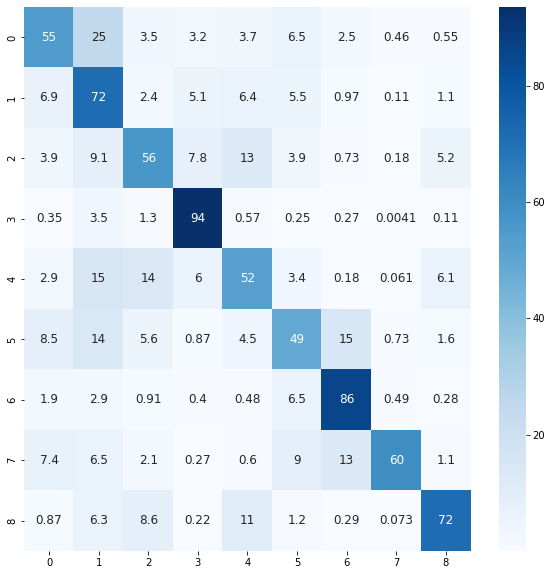

In [ ]:
hard_preds=np.argmax(oof_preds_cat,axis=1)
hard_preds+=1

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, hard_preds,labels=np.unique(y),normalize='true')

import seaborn as sns
plt.figure(figsize=(10,10))
cm*=100
sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 12})

**error analysis**

In [ ]:
hard_preds=np.argmax(oof_preds_cat,axis=1)
hard_preds+=1

In [ ]:
train_preds=pd.DataFrame(oof_preds_cat)
train_preds['label']=y
train_preds['preds']=hard_preds
train_preds['field_id']=free_train['field_id'].values

In [ ]:
missed_5=train_preds[(train_preds.label==5) & (train_preds.preds!=5)]

In [ ]:
missed_5

,0,1,2,3,4,5,6,7,8,label,preds,field_id
0,0.004232,0.071320,0.586994,0.005852,0.288457,0.041259,0.000580,0.000135,0.001172,5,3,43134
5,0.007532,0.130972,0.489267,0.015840,0.126449,0.224901,0.004195,0.000120,0.000725,5,3,91979
22,0.000902,0.003466,0.921764,0.002663,0.066325,0.002652,0.000143,0.000010,0.002075,5,3,85328
29,0.004209,0.095257,0.674839,0.030900,0.183827,0.004115,0.001052,0.000181,0.005621,5,3,114441
32,0.028067,0.019810,0.338389,0.000307,0.266927,0.268869,0.016516,0.001641,0.059475,5,3,9481
...,...,...,...,...,...,...,...,...,...,...,...,...
86797,0.117581,0.262198,0.106841,0.004113,0.197542,0.267048,0.022686,0.004216,0.017774,5,6,117587
86824,0.047739,0.009852,0.364081,0.005498,0.326847,0.172866,0.036833,0.001957,0.034326,5,3,18958
87107,0.071968,0.431772,0.022796,0.272242,0.141670,0.057923,0.000754,0.000566,0.000309,5,2,52820
87109,0.008842,0.101509,0.234676,0.557559,0.032448,0.062805,0.001427,0.000693,0.000041,5,4,86618


In [ ]:
missed_lucrene=train_preds[(train_preds.label==1) & (train_preds.preds==2)]

In [ ]:
missed_lucrene.field_id.values[:20]

array([ 66270, 105550,  23490,  33826,  53468,  20215,   6242,  26177,
        67638, 116376,   2400,   2673,   3458,  27747,  35406,  38868,
        43063,  47236,  61299,  62652])

In [ ]:
ndvi_cols=['field_id']+[f'VV{i}_median_{j}'for i in [1,2] for j in range(4,12)]
ndvi_df=free_train[ndvi_cols]

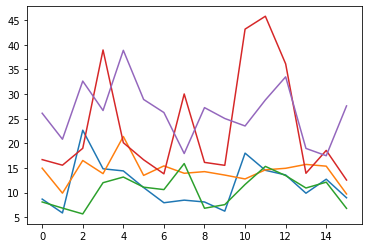

In [ ]:
ll=list(missed_lucrene.field_id.values)
random.shuffle(ll)
l=ll[:5]

for i in l:
  plt.plot(list(ndvi_df[ndvi_df.field_id==i].values)[0][1:])

a lot of misclassified lucrene fields have a particular pattern probably similar to that of pastures

In [ ]:
pasture_df=train_preds[(train_preds.label==2) & (train_preds.preds==2)]

In [ ]:
pasture_df=free_train[(free_train.label==2) ]

In [ ]:
import random
shuffled_pastures=list(pasture_df.field_id.values)

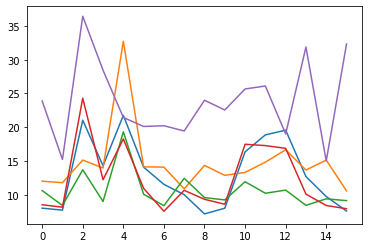

In [ ]:
random.shuffle(shuffled_pastures)
l=shuffled_pastures[:5]
for i in l:
  plt.plot(list(ndvi_df[ndvi_df.field_id==i].values)[0][1:])

In [ ]:
l

[8462, 119203, 94567, 62021, 69079]

In [ ]:
free_train.loc[free_train.field_id==69079,'nir_fluct']

48695    2
Name: nir_fluct, dtype: int64

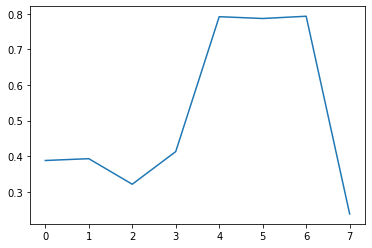

In [ ]:
plt.plot(list(ndvi_df[ndvi_df.field_id==11010].values)[0][1:])

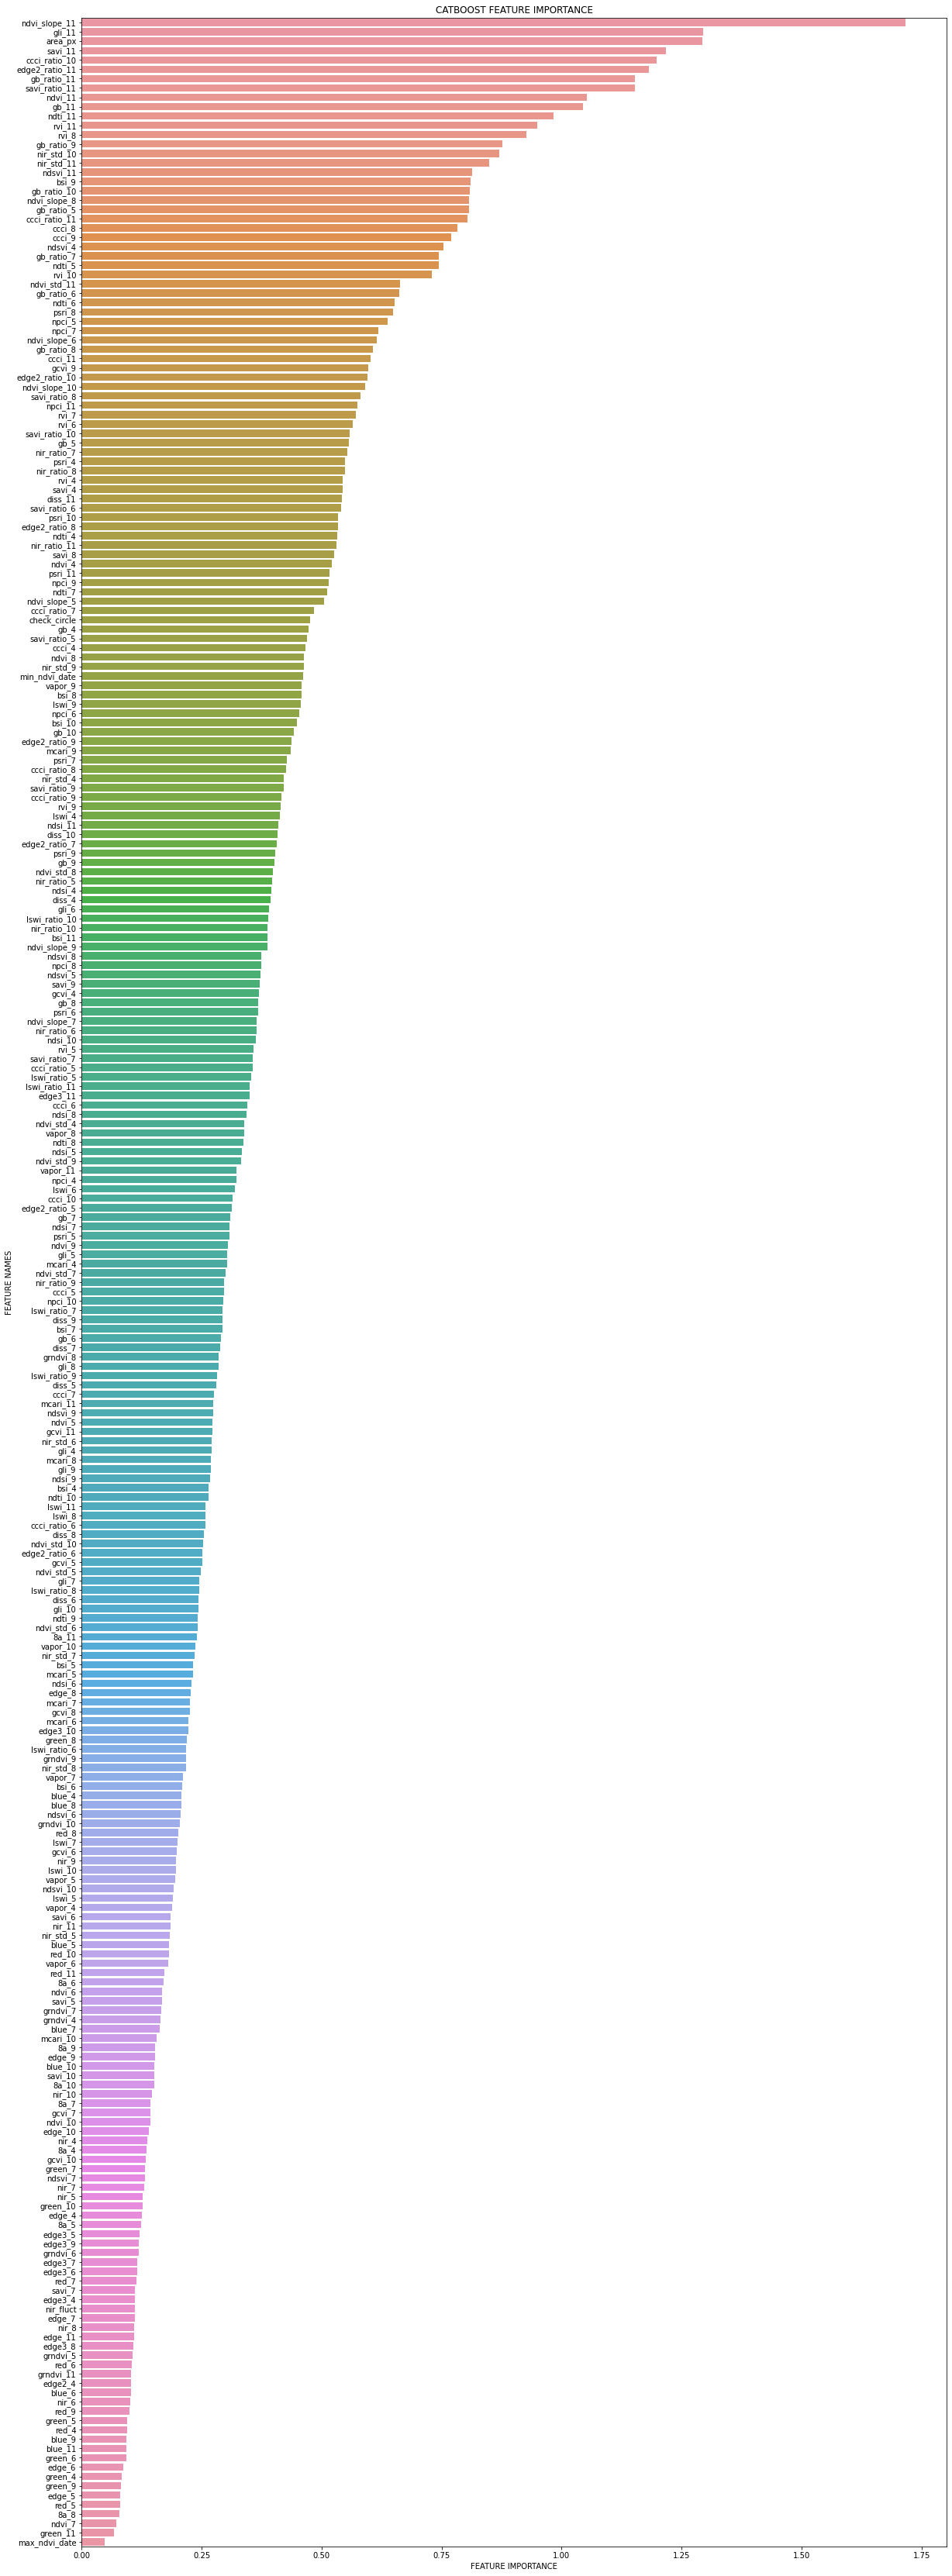

In [ ]:
import seaborn as sns 

def plot_feature_importance(importance,names,model_type):
    
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)
    
  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
    
  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
  #Define size of bar plot
  plt.figure(figsize=(20,60))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(), X.columns,'CATBOOST ')

In [ ]:
#max_ndvi_date/edge /green